# Signal Identification in Time Series using GS Quant (Free Access)
This notebook demonstrates how to use GS Quant free-access functions along with NumPy/Pandas to identify hidden signals in a synthetic time series. We cover trend extraction, rolling statistics, smoothing, and spectral analysis.

## 1️⃣ Create a synthetic time series with a hidden periodic signal

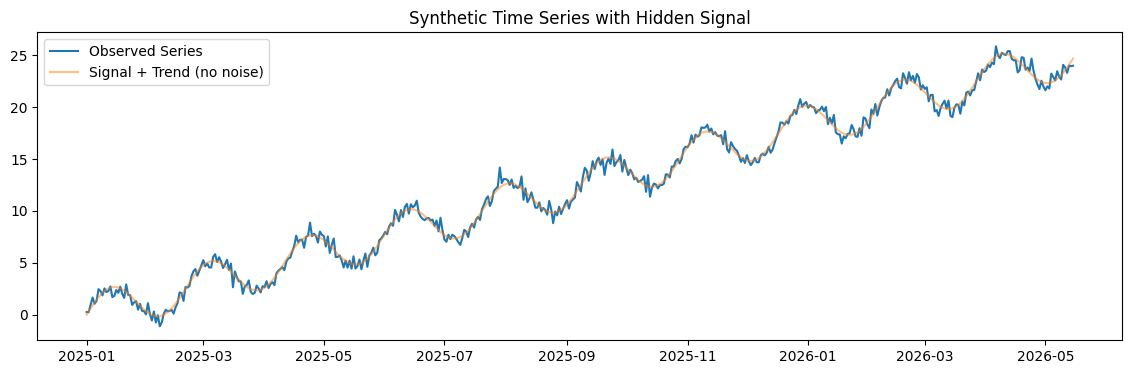

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gs_quant.timeseries import moving_average, volatility, rolling_std, exponential_moving_average
from pandas.tseries.offsets import DateOffset
from gs_quant.data import Dataset
from gs_quant.risk import *
from gs_quant.markets import *

np.random.seed(42)
n = 500

time = np.arange(n)
signal = 2 * np.sin(2 * np.pi * time / 50)
trend_component = 0.05 * time
noise = np.random.normal(0, 0.5, n)

ts_data = trend_component + signal + noise
ts_series = pd.Series(ts_data, index=pd.date_range("2025-01-01", periods=n))

plt.figure(figsize=(14,4))
plt.plot(ts_series, label="Observed Series")
plt.plot(ts_series - noise, label="Signal + Trend (no noise)", alpha=0.5)
plt.legend()
plt.title("Synthetic Time Series with Hidden Signal")
plt.show()

### Explanation:
- `signal`: The hidden periodic component we want to detect.
- `trend_component`: Linear upward trend.
- `noise`: Random fluctuations.
- `ts_series`: Combined observed series.

## 2️⃣ Extract trend using moving average

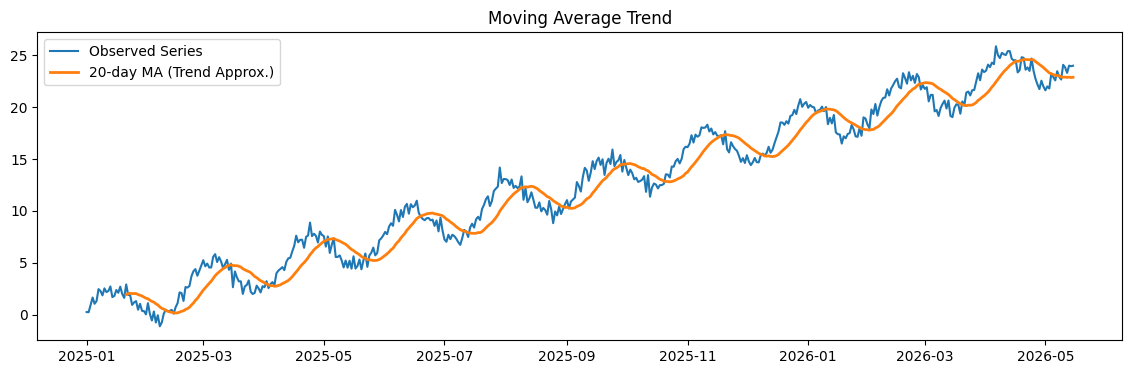

In [2]:
win = 20  # 20-day window
ma = moving_average(ts_series, win)

plt.figure(figsize=(14,4))
plt.plot(ts_series, label="Observed Series")
plt.plot(ma, label="20-day MA (Trend Approx.)", linewidth=2)
plt.legend()
plt.title("Moving Average Trend")
plt.show()

### Explanation:
- `moving_average()` from GS Quant free access: smooths short-term fluctuations to approximate the trend.
- Helps isolate the underlying pattern from noise.

## 3️⃣ Extract linear trend using numpy polyfit

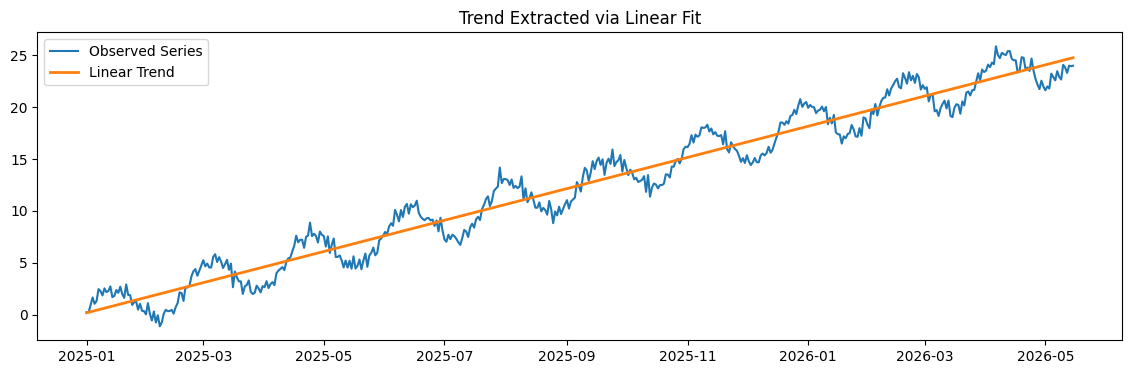

In [3]:
x = np.arange(len(ts_series))
coeff = np.polyfit(x, ts_series.values, 1)  # linear fit
trend_ts = pd.Series(np.polyval(coeff, x), index=ts_series.index)

plt.figure(figsize=(14,4))
plt.plot(ts_series, label="Observed Series")
plt.plot(trend_ts, label="Linear Trend", linewidth=2)
plt.legend()
plt.title("Trend Extracted via Linear Fit")
plt.show()

### Explanation:
- Linear regression isolates the main trend component.
- Subtracting this trend will allow us to focus on the hidden periodic signal.

## 4️⃣ Detrend series

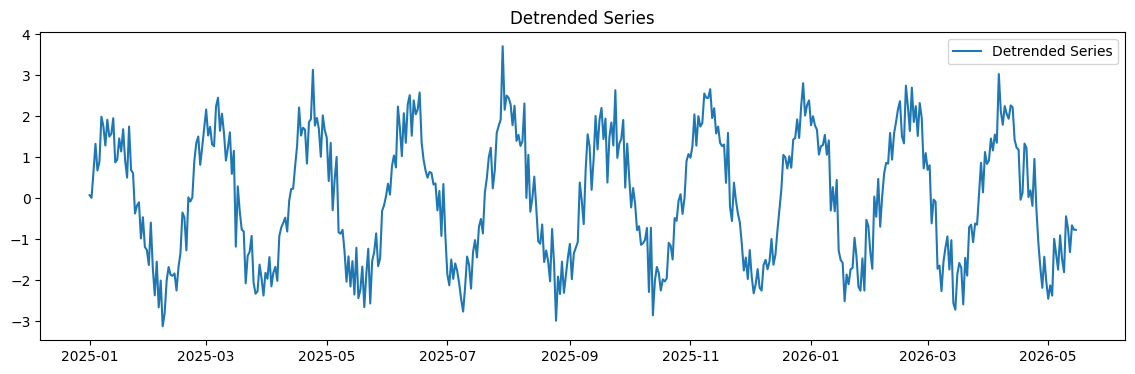

In [4]:
detrended = ts_series - trend_ts
plt.figure(figsize=(14,4))
plt.plot(detrended, label="Detrended Series")
plt.legend()
plt.title("Detrended Series")
plt.show()

### Explanation:
- Removing trend centers the series around zero.
- The detrended series contains the hidden periodic signal plus noise.

## 5️⃣ Rolling statistics for volatility detection

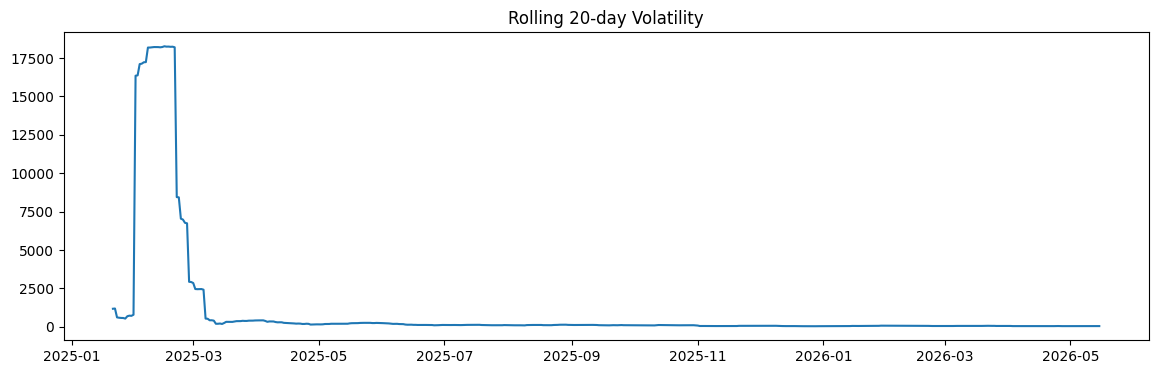

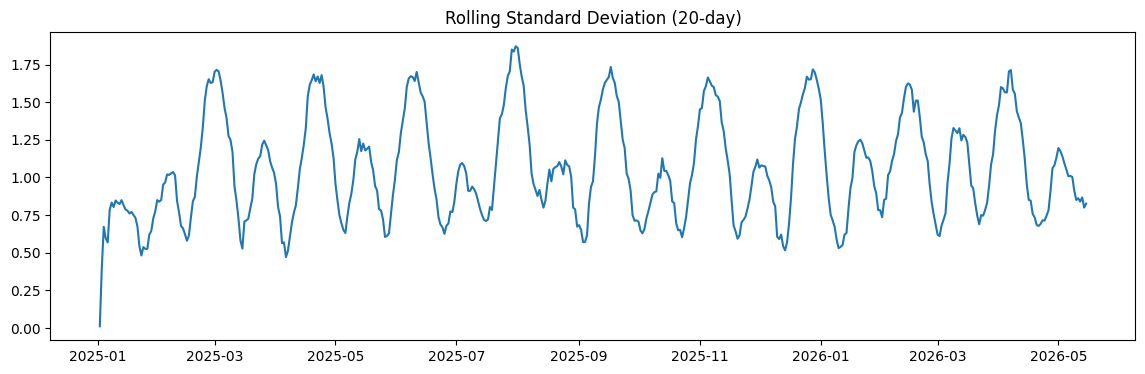

In [5]:
offset = DateOffset(days=20)  # 20-day window
vol = volatility(ts_series, 20)
plt.figure(figsize=(14,4))
plt.plot(vol)
plt.title("Rolling 20-day Volatility")
plt.show()

roll_std = rolling_std(ts_series, offset)
plt.figure(figsize=(14,4))
plt.plot(roll_std)
plt.title("Rolling Standard Deviation (20-day)")
plt.show()

### Explanation:
- `volatility()` and `rolling_std()` detect periods of higher variability.
- Peaks may indicate anomalies or transient events in the signal.

**Key Difference:**
- `volatility()` is return-based and more aligned with financial risk metrics.
- `rolling_std()` is a raw standard deviation of values and is more general for any time series.

Both highlight variability, but:
- `volatility()` emphasizes the magnitude of price/return changes.
- `rolling_std()` emphasizes the spread of actual observed values.


## 6️⃣ Exponential moving average (EMA) smoothing

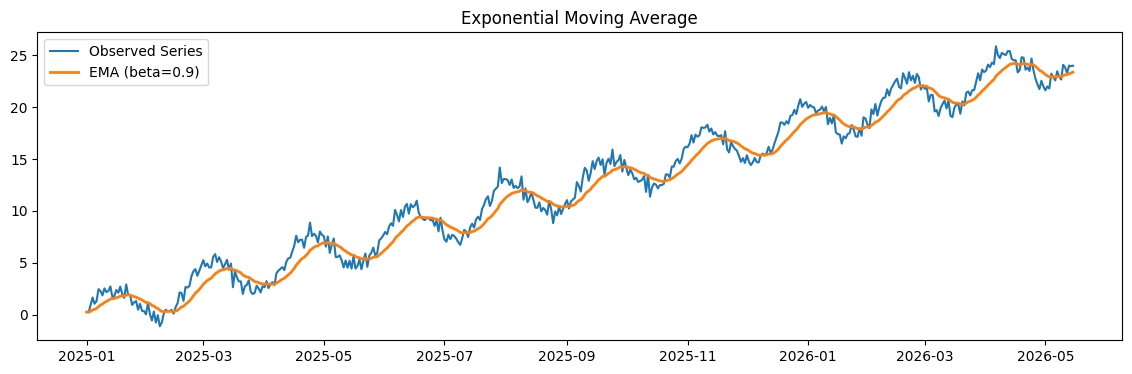

In [6]:
ema = exponential_moving_average(ts_series, beta=0.9)  # smoothing factor
plt.figure(figsize=(14,4))
plt.plot(ts_series, label="Observed Series")
plt.plot(ema, label="EMA (beta=0.9)", linewidth=2)
plt.legend()
plt.title("Exponential Moving Average")
plt.show()

### Explanation:
- EMA emphasizes recent observations.
- Helps to highlight short-term oscillatory signals superimposed on the trend.

## 7️⃣ Spectral analysis using FFT

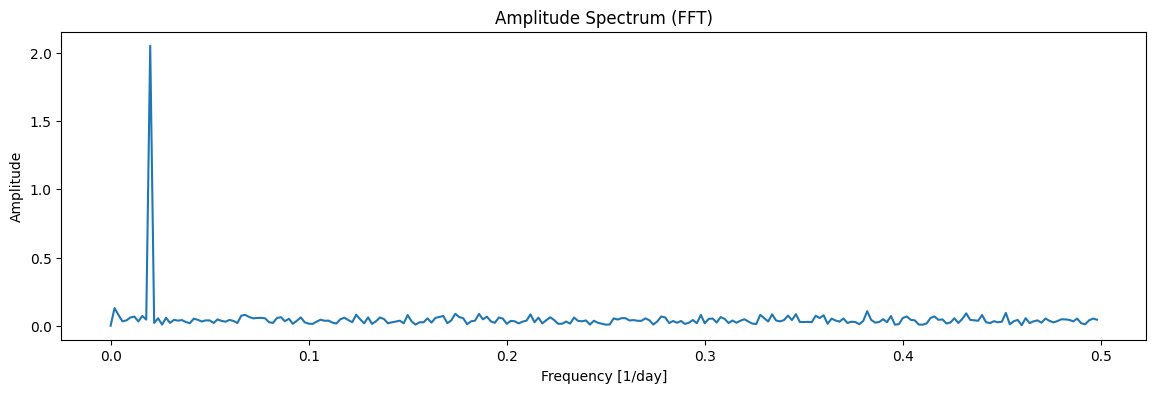

In [7]:
from numpy.fft import fft, fftfreq
y = detrended.values
N = len(y)
T = 1.0  # sampling interval (1 day)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]  # positive frequencies
plt.figure(figsize=(14,4))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title("Amplitude Spectrum (FFT)")
plt.xlabel("Frequency [1/day]")
plt.ylabel("Amplitude")
plt.show()

### Explanation:
- FFT identifies hidden periodic signals in the detrended series.
- Peaks in the spectrum correspond to dominant frequencies (e.g., our synthetic 50-day cycle).
- This is key for signal identification in noisy data.

## 📝 Exercise: Identify a Random Hidden Signal

In this exercise, you will generate a synthetic time series with a **random hidden signal** and attempt to identify it using the techniques learned in this notebook: moving average, linear trend extraction, detrending, rolling statistics, EMA smoothing, and spectral analysis.

You will generate:

- A **random signal function** (choose from sinus, cosinus, square wave, sawtooth, exponential decay)
- Random **signal parameters** (amplitude, frequency, phase)
- A **random linear trend**
- **Random Gaussian noise**

Your task is to extract and analyze the hidden signal.

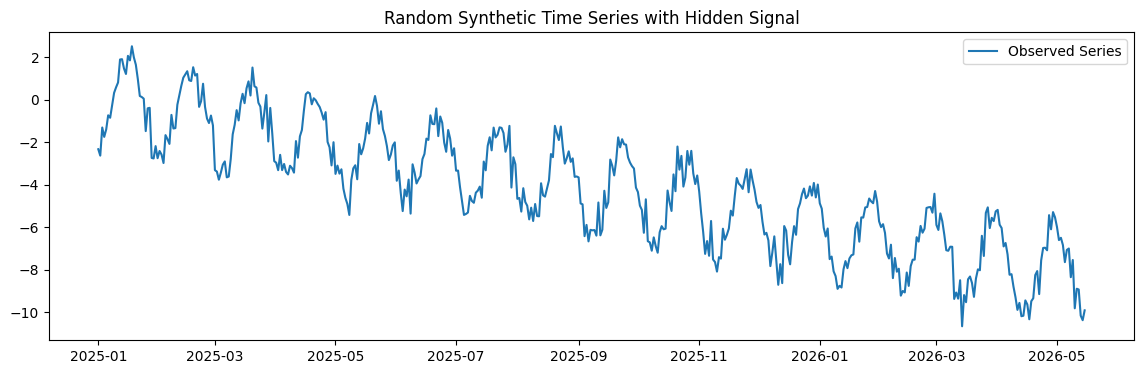

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gs_quant.timeseries import moving_average, volatility, rolling_std, exponential_moving_average
from pandas.tseries.offsets import DateOffset
from scipy import signal as sp_signal  # For square and sawtooth

n = 500
time = np.arange(n)

# ----------------------------
# 1️⃣ Randomly select a signal function
# ----------------------------
signal_funcs = [
    lambda t, A, f, phi: A * np.sin(2*np.pi*f*t + phi),
    lambda t, A, f, phi: A * np.cos(2*np.pi*f*t + phi),
    lambda t, A, f, phi: A * sp_signal.square(2*np.pi*f*t + phi),
    lambda t, A, f, phi: A * sp_signal.sawtooth(2*np.pi*f*t + phi),
    lambda t, A, f, phi: A * np.exp(-0.01*t) * np.sin(2*np.pi*f*t + phi)  # damped sinus
]

sig_func = np.random.choice(signal_funcs)

# ----------------------------
# 2️⃣ Random signal parameters
# ----------------------------
A = np.random.uniform(0.5, 3.0)       # amplitude
f = np.random.uniform(0.01, 0.1)      # frequency
phi = np.random.uniform(0, 2*np.pi)   # phase

# ----------------------------
# 3️⃣ Random trend
# ----------------------------
slope = np.random.uniform(-0.05, 0.05)
trend_component = slope * time

# ----------------------------
# 4️⃣ Random noise
# ----------------------------
noise = np.random.normal(0, 0.5, n)

# ----------------------------
# 5️⃣ Generate observed series
# ----------------------------
signal_component = sig_func(time, A, f, phi)
ts_data = trend_component + signal_component + noise
ts_series = pd.Series(ts_data, index=pd.date_range("2025-01-01", periods=n))

# ----------------------------
# 6️⃣ Plot observed series
# ----------------------------
plt.figure(figsize=(14,4))
plt.plot(ts_series, label="Observed Series")
plt.legend()
plt.title("Random Synthetic Time Series with Hidden Signal")
plt.show()

# ----------------------------
# 7️⃣ Suggested steps to identify the signal:
# - Extract trend using moving_average() or linear fit
# - Detrend the series
# - Compute rolling statistics to detect volatility clusters
# - Apply exponential moving average to smooth short-term noise
# - Use FFT to identify dominant frequency components
# ----------------------------

And now, it's your time to shine !